In [1]:
import numpy as np
import pandas as pd
import nltk
import string
from nltk.corpus import stopwords
import re
from collections import Counter
import itertools
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
eks_defaults_2018 = pd.read_csv('data/2018_defaults.csv',
                                sep = ';',
                                dtype = {'ИНН' : str,
                                         'ИНН контр-та' : str},
                                encoding = 'cp1251')
eks_defaults_2018['Дата пров.'] = np.where(pd.to_datetime(eks_defaults_2018['Дата пров.'],
                                                 format = '%d.%m.%Y %H:%M:%S',
                                                 errors = 'coerce').isnull(),
                                           pd.to_datetime(eks_defaults_2018['Дата пров.'],
                                                 format = '%d.%m.%Y',
                                                 errors = 'coerce'),
                                           pd.to_datetime(eks_defaults_2018['Дата пров.'],
                                                 format = '%d.%m.%Y %H:%M:%S',
                                                 errors = 'coerce'))
eks_defaults_2018 = eks_defaults_2018.dropna(subset = ['Счёт-корресп-т'])

In [3]:
eks_defaults_2018.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 67387 entries, 1 to 67413
Data columns (total 11 columns):
ИНН               67387 non-null object
Клиент            67387 non-null object
Счет              67387 non-null object
Дата пров.        67387 non-null datetime64[ns]
Сумма деб         27890 non-null float64
Сумма кр          39430 non-null float64
Счёт-корресп-т    67387 non-null object
Счет контр-та     67381 non-null object
ИНН контр-та      67322 non-null object
Контр-т           67387 non-null object
Назн-е плат       67387 non-null object
dtypes: datetime64[ns](1), float64(2), object(8)
memory usage: 6.2+ MB


In [4]:
# Стеммер Портера (спасибо Kein1945 с гитхаба)
class Porter:
    PERFECTIVEGROUND =  re.compile(u"((ив|ивши|ившись|ыв|ывши|ывшись)|((?<=[ая])(в|вши|вшись)))$")
    REFLEXIVE = re.compile(u"(с[яь])$")
    ADJECTIVE = re.compile(u"(ее|ие|ые|ое|ими|ыми|ей|ий|ый|ой|ем|им|ым|ом|его|ого|ему|ому|их|ых|ую|юю|ая|яя|ою|ею)$")
    PARTICIPLE = re.compile(u"((ивш|ывш|ующ)|((?<=[ая])(ем|нн|вш|ющ|щ)))$")    
    VERB = re.compile(u"((ила|ыла|ена|ейте|уйте|ите|или|ыли|ей|уй|ил|ыл|им|ым|ен|ило|ыло|ено|ят|ует|уют|ит|ыт|ены|ить|ыть|ишь|ую|ю)|((?<=[ая])(ла|на|ете|йте|ли|й|л|ем|н|ло|но|ет|ют|ны|ть|ешь|нно)))$")
    NOUN = re.compile(u"(а|ев|ов|ие|ье|е|иями|ями|ами|еи|ии|и|ией|ей|ой|ий|й|иям|ям|ием|ем|ам|ом|о|у|ах|иях|ях|ы|ь|ию|ью|ю|ия|ья|я)$")
    RVRE = re.compile(u"^(.*?[аеиоуыэюя])(.*)$")
    DERIVATIONAL = re.compile(u".*[^аеиоуыэюя]+[аеиоуыэюя].*ость?$")
    DER = re.compile(u"ость?$")
    SUPERLATIVE = re.compile(u"(ейше|ейш)$")
    I = re.compile(u"и$")
    P = re.compile(u"ь$")
    NN = re.compile(u"нн$")
    def stem(word):
        word = word.lower()
        word = word.replace(u'ё', u'е')
        m = re.match(Porter.RVRE, word)
        if m and m.groups():
            pre = m.group(1)
            rv = m.group(2)
            temp = Porter.PERFECTIVEGROUND.sub('', rv, 1)
            if temp == rv:
                rv = Porter.REFLEXIVE.sub('', rv, 1)
                temp = Porter.ADJECTIVE.sub('', rv, 1)
                if temp != rv:
                    rv = temp
                    rv = Porter.PARTICIPLE.sub('', rv, 1)
                else:
                    temp = Porter.VERB.sub('', rv, 1)
                    if temp == rv:
                        rv = Porter.NOUN.sub('', rv, 1)
                    else:
                        rv = temp
            else:
                rv = temp
            rv = Porter.I.sub('', rv, 1)
            if re.match(Porter.DERIVATIONAL, rv):
                rv = Porter.DER.sub('', rv, 1)
            temp = Porter.P.sub('', rv, 1)
            if temp == rv:
                rv = Porter.SUPERLATIVE.sub('', rv, 1)
                rv = Porter.NN.sub(u'н', rv, 1)
            else:
                rv = temp
            word = pre+rv
        return word
    stem = staticmethod(stem)

In [5]:
#nltk.data.path
def custom_tokenize(file_text):
    file_text = file_text.lower() # приводим к нижнему регистру
    file_text = re.sub(r'\d+', '', file_text) # убираем числа
    file_text = file_text.translate(str.maketrans("","", string.punctuation)) # убираем пунктуацию
    file_text = file_text.replace('№', '')
    tokens = nltk.word_tokenize(file_text) # токенизируем
    stop_words = stopwords.words('russian') # определяем русские стоп-слова
    stop_words.extend(['что', 'это', 'так', 'вот', 'быть', 'как', 'в', 'с', '—', 'к', 'на','т','ч',
                       'рублей', 'рубль', 'руб', 'rub', 'rur', 'тыс', 'г']) # расширяем список стоп-слов
    tokens = [i for i in tokens if ( i not in stop_words )] # убираем стоп-слова
    tokens = [i.replace("«", "").replace("»", "") for i in tokens] # убираем всякие кавычки
    tokens = list(map(Porter.stem, tokens)) # оставляем только корень слова    
    trash = ['договор', 'документ', 'счет', 'платеж', 'плат', 'оплат', 'дооплат', 'доплат', 'сумм', 'числ', 'номер', 'клиент', 'тс', 'кс', 'ам', 'аа', 'ма', 'п', 'д', 'зна', 'ю', 'п', 'кд', 'средств', 'пег', 'период', 'n', 'бн']
    tokens = [i for i in tokens if ( i not in trash )]    
    return tokens

In [6]:
custom_tokenize(eks_defaults_2018['Назн-е плат'][1])

['счтм', 'краск', 'фасадн', 'ндс']

In [7]:
eks_defaults_2018['Назн-е плат обраб'] = list(map(custom_tokenize, eks_defaults_2018['Назн-е плат'].fillna('пусто')))
eks_defaults_2018.head(10)

,ИНН,Клиент,Счет,Дата пров.,Сумма деб,Сумма кр,Счёт-корресп-т,Счет контр-та,ИНН контр-та,Контр-т,Назн-е плат,Назн-е плат обраб
1,7730608362,"ООО ""777 СЕРВИС""",40702810738260013504,2018-01-09 12:21:08,84877.10,NaN,30301810438006000000,40702810280000000869,7802094775,"ЗАО ""КАЙМАН""",ОПЛАТА ПО СЧЕТУ № СЧТМ-0000003 ОТ 09.01.2018Г....,"[счтм, краск, фасадн, ндс]"
2,7730608362,"ООО ""777 СЕРВИС""",40702810738260013504,2018-01-09 15:01:13,30000.00,NaN,30301810438006000000,40702810900050000758,7705868695,"ООО ""СТУДИЯ ДИЗАЙНА СТЕКЛА""","ДОПЛАТА АВАНСА ПО СЧЕТУ №30 ОТ 07.12.2017., ПО...","[аванс, подряд, ндс]"
3,7730608362,"ООО ""777 СЕРВИС""",40702810738260013504,2018-01-09 15:25:48,90000.00,NaN,40702810138260016114,40702810138260016114,7730640976,"ООО ""ИВИС""",АРЕНДНАЯ ПЛАТА ПО СЧЕТУ №012 ОТ 01.12. 2017 Г....,"[арендн, ндс, облага]"
4,7730608362,"ООО ""777 СЕРВИС""",40702810738260013504,2018-01-09 16:01:16,110000.00,NaN,30301810438006000000,40703810401300000031,7736243693,"Ассоциация СРО ""МОС""","ОПЛАТА ПО СЧЕТУ №986 ОТ 20.12.2017Г., ЧЛЕНСКИЙ...","[членск, взнос, ндс, облага]"
5,7730608362,"ООО ""777 СЕРВИС""",40702810738260013504,2018-01-09 18:51:11,1036.44,NaN,30301810938004200014,474278107001400100010419,7707083893,ПАО СБЕРБАНК,ПОГАШЕНИЕ ПРОЦЕНТОВ ЗА КРЕДИТ ПО ДОГОВОРУ НОМЕ...,"[погашен, процент, кред, juvyfmyqqrauzb, декаб..."
6,7730608362,"ООО ""777 СЕРВИС""",40702810738260013504,2018-01-09 18:52:49,219751.32,NaN,30301810938004200014,45204810200140003652,7707083893,ПАО СБЕРБАНК,ПОГАШЕНИЕ КРЕДИТА ПО ДОГОВОРУ 3800JUVYFMYQ1Q0R...,"[погашен, кредит, juvyfmyqqrauzb, декабр, оо, ..."
7,7730608362,"ООО ""777 СЕРВИС""",40702810738260013504,2018-01-09 21:44:24,11.00,NaN,70601810238002720202,70601810238002720202,7707083893,Московский банк Сбербанка России,КОМИССИЯ ВНУТРИ СБЕРБАНКА ЗА ПП/ПТ ЧЕРЕЗ ДБО С...,"[комисс, внутр, сбербанк, пппт, дбо, согласн, ..."
8,7730608362,"ООО ""777 СЕРВИС""",40702810738260013504,2018-01-09 21:44:25,96.00,NaN,70601810238002720202,70601810238002720202,7707083893,Московский банк Сбербанка России,КОМИССИЯ В ДРУГИЕ БАНКИ (КРЕДИТНЫЕ ОРГАНИЗАЦИИ...,"[комисс, друг, банк, кредитн, организац, банк,..."
9,7730608362,"ООО ""777 СЕРВИС""",40702810738260013504,2018-01-10 15:38:20,400200.00,NaN,30301810438006000000,40817810951104005738,771876285287,Кривчик Олег Евгеньевич,ОПЛАТА ПО ДОГОВОРУ Б/Н ОТ 09.01.2017Г. ЗА АРЕН...,"[аренд, нежил, помещен, ндс, облага]"
10,7730608362,"ООО ""777 СЕРВИС""",40702810738260013504,2018-01-10 15:44:46,59800.00,NaN,30301810438006000000,40101810045250010041,7730057570,УФК по г. Москве (УФНС России по г. Москве №30...,НДФЛ ЗА ЯНВАРЬ 2018 Г. НДС НЕ ОБЛАГАЕТСЯ.,"[ндфл, январ, ндс, облага]"


In [8]:
default_dates_2018 = pd.DataFrame(
    data = {
        'ИНН' : [5001078545,7706526609,7708131540,7708795244,7710058336,7722567708,7730616074,7719665494,7730608362,7715773555,7721163646,7721539024,7721591610,7721775960,7726064857,7727707927,7733250660,7733617904,7734226452,7736196387,7743775032],
        'Дата дефолта' : ['17-08-2018','25-06-2018','20-09-2018','17-10-2018','28-04-2018','20-08-2018','12-07-2018','30-10-2018','30-11-2018','19-11-2018','20-03-2018','28-05-2018','27-06-2018','20-11-2018','20-06-2018','15-02-2018','29-03-2018','20-04-2018','20-07-2018','15-10-2018','03-05-2018']
    }
)
default_dates_2018['ИНН'] = default_dates_2018['ИНН'].astype(str)
default_dates_2018['Дата дефолта'] = pd.to_datetime(default_dates_2018['Дата дефолта'], format = '%d-%m-%Y')
default_dates_2018.head()

,Дата дефолта,ИНН
0,2018-08-17,5001078545
1,2018-06-25,7706526609
2,2018-09-20,7708131540
3,2018-10-17,7708795244
4,2018-04-28,7710058336


In [9]:
eks_defaults_2018 = pd.merge(eks_defaults_2018,
                             default_dates_2018,
                             on = 'ИНН')
months_till_default = []
payment_purpose = []
for i in range(len(eks_defaults_2018)):
    cnt_months_till_default = eks_defaults_2018['Дата дефолта'][i].to_period('M') - eks_defaults_2018['Дата пров.'][i].to_period('M')
    cnt_payment_purpose = ' '.join(eks_defaults_2018['Назн-е плат обраб'][i])
    payment_purpose.append(cnt_payment_purpose)
    months_till_default.append(cnt_months_till_default)
eks_defaults_2018['Мес. до дефолта'] = months_till_default
eks_defaults_2018['Назн. плат. str'] = payment_purpose
eks_defaults_2018.head(3)

,ИНН,Клиент,Счет,Дата пров.,Сумма деб,Сумма кр,Счёт-корресп-т,Счет контр-та,ИНН контр-та,Контр-т,Назн-е плат,Назн-е плат обраб,Дата дефолта,Мес. до дефолта,Назн. плат. str
0,7730608362,"ООО ""777 СЕРВИС""",40702810738260013504,2018-01-09 12:21:08,84877.1,NaN,30301810438006000000,40702810280000000869,7802094775,"ЗАО ""КАЙМАН""",ОПЛАТА ПО СЧЕТУ № СЧТМ-0000003 ОТ 09.01.2018Г....,"[счтм, краск, фасадн, ндс]",2018-11-30,10,счтм краск фасадн ндс
1,7730608362,"ООО ""777 СЕРВИС""",40702810738260013504,2018-01-09 15:01:13,30000.0,NaN,30301810438006000000,40702810900050000758,7705868695,"ООО ""СТУДИЯ ДИЗАЙНА СТЕКЛА""","ДОПЛАТА АВАНСА ПО СЧЕТУ №30 ОТ 07.12.2017., ПО...","[аванс, подряд, ндс]",2018-11-30,10,аванс подряд ндс
2,7730608362,"ООО ""777 СЕРВИС""",40702810738260013504,2018-01-09 15:25:48,90000.0,NaN,40702810138260016114,40702810138260016114,7730640976,"ООО ""ИВИС""",АРЕНДНАЯ ПЛАТА ПО СЧЕТУ №012 ОТ 01.12. 2017 Г....,"[арендн, ндс, облага]",2018-11-30,10,арендн ндс облага


In [10]:
#import psutil
#svmem_values = psutil.virtual_memory()
#svmem_total = svmem_values.total >> 20 # 30 - GB; 20 - MB
#svmem_total

In [11]:
pieces = []
for m,inn in itertools.product(list(eks_defaults_2018['Мес. до дефолта'].unique()),
                               list(eks_defaults_2018['ИНН'].unique())):
    filtered = eks_defaults_2018['Назн. плат. str'].loc[(eks_defaults_2018['Мес. до дефолта'] == m) & (eks_defaults_2018['ИНН'] == inn)]
    counter = list(Counter(' '.join(filtered).split()).items())
    total = sum(filtered.str.count(' ') + 1)
    frequency = list(map(lambda x : x / total, list(dict(counter).values())))
    frame = pd.DataFrame(data = counter, columns = ['Слово', 'Частота'])
    frame['Относительная частота'] = frequency
    frame['ИНН'] = inn
    frame['Мес. до дефолта'] = m
    pieces.append(frame)
default_words = pd.concat(pieces, ignore_index = True)
default_words.sort_values(by = ['ИНН','Мес. до дефолта','Относительная частота'],
                          ascending = False,
                          inplace = True)
default_words.head(5)

,Слово,Частота,Относительная частота,ИНН,Мес. до дефолта
14822,ндс,1677,0.107971,7743775032,4
14823,облага,1261,0.081187,7743775032,4
14836,реестр,1100,0.070822,7743775032,4
14839,комисс,991,0.063804,7743775032,4
14837,мерчант,900,0.057945,7743775032,4


In [12]:
default_words = default_words.loc[default_words['Относительная частота'] > 0.0001]

In [13]:
pivot_default_words = pd.pivot_table(data = default_words,
                                     values = 'Относительная частота',
                                     index = 'Слово',
                                     columns = 'Мес. до дефолта',
                                     aggfunc = np.mean,
                                     fill_value = 0)
pivot_default_words.sort_values(by = [1], ascending = False)

Мес. до дефолта,0,1,2,3,4,5,6,7,8,9,10
Слово,,,,,,,,,,,
ндс,0.110773,0.116761,0.108833,0.115168,0.127284,0.130284,0.133112,0.137782,0.123925,0.136774,0.130184
полистирол,0.021583,0.091877,0.049853,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
предварительн,0.000000,0.076923,0.000125,0.000000,0.001242,0.000660,0.001114,0.000000,0.000000,0.000000,0.000000
соглписьм,0.000000,0.076923,0.000000,0.000138,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
неполучен,0.000974,0.076923,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
денег,0.000000,0.076923,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
инкассирова,0.030303,0.059925,0.050542,0.026002,0.049618,0.014363,0.000000,0.000000,0.000000,0.000000,0.000000
агрегат,0.000000,0.058824,0.000000,0.007353,0.000000,0.000398,0.001665,0.003376,0.002701,0.000629,0.000000
мосп,0.000000,0.055263,0.001157,0.000862,0.000620,0.001319,0.000000,0.000558,0.000000,0.001698,0.000000


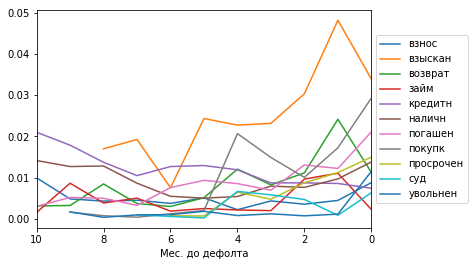

In [14]:
default_words[default_words[
    'Слово'].isin(['займ',
                   'погашен',
                   'просрочен',
                   'возврат',
                   'взыскан',
                   'наличн',
                   'кредитн',
                   'покупк',
                   'взнос',
                   'увольнен',
                   'суд'
                  ])].pivot_table('Относительная частота',
                                  index = 'Мес. до дефолта',
                                  columns = 'Слово',
                                  aggfunc = 'mean'
                                 ).plot().legend(loc = 'center left',
                                                 bbox_to_anchor=(1,.5))
plt.gca().invert_xaxis()

In [15]:
default_words.loc[default_words['Относительная частота'] < 0.0001].shape

(0, 5)

In [16]:
default_words.shape

(31302, 5)

In [17]:
eks_notdefaults_2018 = pd.read_csv('data/2018_notdefaults.csv',
                                sep = ';',
                                dtype = {'ИНН' : str,
                                         'ИНН контр-та' : str},
                                encoding = 'cp1251')
eks_notdefaults_2018['Дата пров.'] = np.where(pd.to_datetime(eks_notdefaults_2018['Дата пров.'],
                                                 format = '%d.%m.%Y %H:%M:%S',
                                                 errors = 'coerce').isnull(),
                                           pd.to_datetime(eks_notdefaults_2018['Дата пров.'],
                                                 format = '%d.%m.%Y',
                                                 errors = 'coerce'),
                                           pd.to_datetime(eks_notdefaults_2018['Дата пров.'],
                                                 format = '%d.%m.%Y %H:%M:%S',
                                                 errors = 'coerce'))
eks_notdefaults_2018 = eks_notdefaults_2018.dropna(subset = ['Счёт-корресп-т'])

In [18]:
eks_notdefaults_2018['Назн-е плат обраб'] = list(map(custom_tokenize, eks_notdefaults_2018['Назн-е плат'].fillna('пусто')))
eks_notdefaults_2018.head(10)

,ИНН,Клиент,Счет,Дата пров.,Сумма деб,Сумма кр,Счёт-корресп-т,Счет контр-та,ИНН контр-та,Контр-т,Назн-е плат,Назн-е плат обраб
0,5001026970,"ОАО ""ФАБЕРЛИК""",40702978238000006935,2018-05-17 13:04:43,NaN,282760.8,40702978538001006935,40702978538001006935,5001026970,"ОАО ""ФАБЕРЛИК""",ЗАЧИСЛЕНИЕ ИНВАЛЮТЫ ПО ОПЕРАЦИИ ОБЯЗАТЕЛЬНОЙ П...,"[зачислен, инвалют, операц, обязательн, продаж..."
1,5001026970,"ОАО ""ФАБЕРЛИК""",40702978238000006935,2018-05-17 23:59:59,282760.8,NaN,30220978838000001000,30301978338006000000,7707083893,Московский банк Сбербанка России,ADVANCE PAYMENT UNDER CONTRACT: 2/007/16/12/05...,"[advance, payment, under, contract, dtd, invoi..."
2,5001026970,"ОАО ""ФАБЕРЛИК""",40702978238000006935,2018-06-29 17:43:49,NaN,27600.0,40702978538001006935,40702978538001006935,5001026970,"ОАО ""ФАБЕРЛИК""",ЗАЧИСЛЕНИЕ ИНВАЛЮТЫ ПО ОПЕРАЦИИ ОБЯЗАТЕЛЬНОЙ П...,"[зачислен, инвалют, операц, обязательн, продаж..."
3,5001026970,"ОАО ""ФАБЕРЛИК""",40702978238000006935,2018-06-30 00:00:00,NaN,NaN,70603810738002630201,40702978238000006935,5001026970,"ОАО ""ФАБЕРЛИК""",ПЕРЕОЦЕНКА СЧЕТА. 27600 EUR ПО КУРСУ 72.9921,"[переоценк, eur, курс]"
4,5001026970,"ОАО ""ФАБЕРЛИК""",40702978238000006935,2018-07-02 12:37:10,27600.0,NaN,30301978338006000000,30301978338006000000,7707083893,Московский банк Сбербанка России,PAYMENT TO CONTRACT: BINDER -2017 DTD 2...,"[payment, to, contract, binder, dtd, proformai..."
5,5001026970,"ОАО ""ФАБЕРЛИК""",40702978238000006935,2018-08-28 16:54:35,NaN,76751.2,30302978638006000000,30302978638006000000,7707083893,ОТДЕЛ УЧЕТА ОПЕРАЦИЙ НА ДЕНЕЖНОМ РЫНКЕ,ПЕРЕВОД СРЕДСТВ ПО ФОРЕКСНОЙ СДЕЛКЕОТ 28/08/20...,"[перевод, форексн, сделкеот, курс, контрвалют,..."
6,5001026970,"ОАО ""ФАБЕРЛИК""",40702978238000006935,2018-08-28 23:59:59,76751.2,NaN,30220978838000001000,30301978338006000000,7707083893,Московский банк Сбербанка России,PMNT. TO CONTRACT: 2/0 07/16/12/05...,"[pmnt, to, contract, dtd, inv, dtd, for, equip..."
7,5001026970,"ОАО ""ФАБЕРЛИК""",40702978538001006935,2018-05-17 11:00:12,NaN,282760.8,30302978638006000000,30302978638006000000,7707083893,AO RAIFFEISENBANK 17/1 TROITS...,FX DEAL DD 16.05.2018,"[fx, deal, dd]"
8,5001026970,"ОАО ""ФАБЕРЛИК""",40702978538001006935,2018-05-17 13:04:43,282760.8,NaN,40702978238000006935,40702978238000006935,5001026970,"ОАО ""ФАБЕРЛИК""",ЗАЧИСЛЕНИЕ ИНВАЛЮТЫ ПО ОПЕРАЦИИ ОБЯЗАТЕЛЬНОЙ П...,"[зачислен, инвалют, операц, обязательн, продаж..."
9,5001026970,"ОАО ""ФАБЕРЛИК""",40702978538001006935,2018-06-29 16:35:12,NaN,27600.0,30302978638006000000,30302978638006000000,7707083893,AO RAIFFEISENBANK 17/1 TROITS...,FX DEAL DD 29.06.2018,"[fx, deal, dd]"


In [19]:
months_till_default = []
payment_purpose = []
for i in range(len(eks_notdefaults_2018)):
    cnt_months_till_default = eks_notdefaults_2018['Дата пров.'][i].month
    cnt_payment_purpose = ' '.join(eks_notdefaults_2018['Назн-е плат обраб'][i])
    payment_purpose.append(cnt_payment_purpose)
    months_till_default.append(cnt_months_till_default)
eks_notdefaults_2018['Мес.'] = months_till_default
eks_notdefaults_2018['Назн. плат. str'] = payment_purpose
eks_notdefaults_2018.head(3)

,ИНН,Клиент,Счет,Дата пров.,Сумма деб,Сумма кр,Счёт-корресп-т,Счет контр-та,ИНН контр-та,Контр-т,Назн-е плат,Назн-е плат обраб,Мес.,Назн. плат. str
0,5001026970,"ОАО ""ФАБЕРЛИК""",40702978238000006935,2018-05-17 13:04:43,NaN,282760.8,40702978538001006935,40702978538001006935,5001026970,"ОАО ""ФАБЕРЛИК""",ЗАЧИСЛЕНИЕ ИНВАЛЮТЫ ПО ОПЕРАЦИИ ОБЯЗАТЕЛЬНОЙ П...,"[зачислен, инвалют, операц, обязательн, продаж...",5,зачислен инвалют операц обязательн продаж валю...
1,5001026970,"ОАО ""ФАБЕРЛИК""",40702978238000006935,2018-05-17 23:59:59,282760.8,NaN,30220978838000001000,30301978338006000000,7707083893,Московский банк Сбербанка России,ADVANCE PAYMENT UNDER CONTRACT: 2/007/16/12/05...,"[advance, payment, under, contract, dtd, invoi...",5,advance payment under contract dtd invoice b d...
2,5001026970,"ОАО ""ФАБЕРЛИК""",40702978238000006935,2018-06-29 17:43:49,NaN,27600.0,40702978538001006935,40702978538001006935,5001026970,"ОАО ""ФАБЕРЛИК""",ЗАЧИСЛЕНИЕ ИНВАЛЮТЫ ПО ОПЕРАЦИИ ОБЯЗАТЕЛЬНОЙ П...,"[зачислен, инвалют, операц, обязательн, продаж...",6,зачислен инвалют операц обязательн продаж валю...


In [20]:
pieces = []
for m,inn in itertools.product(list(eks_notdefaults_2018['Мес.'].unique()),
                               list(eks_notdefaults_2018['ИНН'].unique())):
    filtered = eks_notdefaults_2018['Назн. плат. str'].loc[(eks_notdefaults_2018['Мес.'] == m) & (eks_notdefaults_2018['ИНН'] == inn)]
    counter = list(Counter(' '.join(filtered).split()).items())
    total = sum(filtered.str.count(' ') + 1)
    frequency = list(map(lambda x : x / total, list(dict(counter).values())))
    frame = pd.DataFrame(data = counter, columns = ['Слово', 'Частота'])
    frame['Относительная частота'] = frequency
    frame['ИНН'] = inn
    frame['Мес.'] = m
    pieces.append(frame)
notdefault_words = pd.concat(pieces, ignore_index = True)
notdefault_words.sort_values(by = ['ИНН','Мес.','Относительная частота'],
                          ascending = False,
                          inplace = True)
notdefault_words.head(5)

,Слово,Частота,Относительная частота,ИНН,Мес.
90987,ндс,581,0.112379,7731644035,12
91018,займ,427,0.082592,7731644035,12
91019,тв,386,0.074662,7731644035,12
91006,перечислен,357,0.069052,7731644035,12
91025,облага,325,0.062863,7731644035,12


In [21]:
pivot_notdefault_words = pd.pivot_table(data = notdefault_words,
                                        values = 'Относительная частота',
                                        index = 'Слово',
                                        columns = 'Мес.',
                                        aggfunc = np.mean,
                                        fill_value = 0)
pivot_notdefault_words.sort_values(by = [1], ascending = False)

Мес.,1,2,3,4,5,6,7,8,9,10,11,12
Слово,,,,,,,,,,,,
ндс,0.128312,0.122019,0.123132,0.132867,0.134754,0.129350,0.130417,0.136952,0.125880,0.125493,0.127385,0.124848
тч,0.057326,0.052795,0.054264,0.063309,0.063649,0.060017,0.062898,0.076883,0.058658,0.057524,0.052711,0.057316
реестр,0.031688,0.037786,0.033213,0.026440,0.033370,0.031738,0.031802,0.033329,0.034739,0.033945,0.034938,0.034093
регистр,0.028269,0.022684,0.016736,0.000000,0.000000,0.000000,0.013043,0.000000,0.026882,0.020979,0.028754,0.000000
рзр,0.028014,0.024461,0.024258,0.015950,0.010966,0.017192,0.014074,0.015721,0.024037,0.017198,0.023214,0.024351
соответств,0.026968,0.028705,0.027189,0.017773,0.030941,0.028162,0.027232,0.026693,0.028537,0.024192,0.030291,0.024935
целев,0.025612,0.028467,0.024372,0.000070,0.006877,0.013262,0.016946,0.023640,0.030251,0.025500,0.027181,0.025672
тв,0.023676,0.027323,0.017767,0.000000,0.009637,0.008903,0.009517,0.020202,0.026935,0.023517,0.019622,0.074662
тск,0.022360,0.019423,0.021331,0.023931,0.020065,0.016681,0.040213,0.045972,0.020782,0.020025,0.020161,0.018543


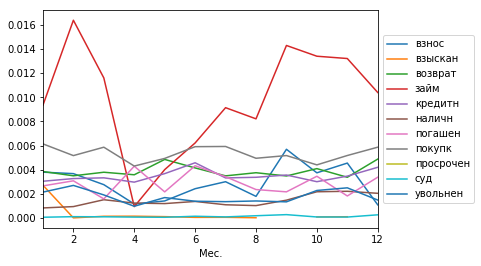

In [22]:
notdefault_words[notdefault_words['Слово'].isin(
    ['займ',
     'погашен',
     'просрочен',
     'возврат',
     'взыскан',
     'наличн',
     'кредитн',
     'покупк',
     'взнос',
     'увольнен',
     'суд'])].pivot_table('Относительная частота',
                          index = 'Мес.',
                          columns = 'Слово',
                          aggfunc = 'mean').plot().legend(loc = 'center left',
                                                          bbox_to_anchor=(1,.5))

In [23]:
eks_defaults_2018.head(3)

,ИНН,Клиент,Счет,Дата пров.,Сумма деб,Сумма кр,Счёт-корресп-т,Счет контр-та,ИНН контр-та,Контр-т,Назн-е плат,Назн-е плат обраб,Дата дефолта,Мес. до дефолта,Назн. плат. str
0,7730608362,"ООО ""777 СЕРВИС""",40702810738260013504,2018-01-09 12:21:08,84877.1,NaN,30301810438006000000,40702810280000000869,7802094775,"ЗАО ""КАЙМАН""",ОПЛАТА ПО СЧЕТУ № СЧТМ-0000003 ОТ 09.01.2018Г....,"[счтм, краск, фасадн, ндс]",2018-11-30,10,счтм краск фасадн ндс
1,7730608362,"ООО ""777 СЕРВИС""",40702810738260013504,2018-01-09 15:01:13,30000.0,NaN,30301810438006000000,40702810900050000758,7705868695,"ООО ""СТУДИЯ ДИЗАЙНА СТЕКЛА""","ДОПЛАТА АВАНСА ПО СЧЕТУ №30 ОТ 07.12.2017., ПО...","[аванс, подряд, ндс]",2018-11-30,10,аванс подряд ндс
2,7730608362,"ООО ""777 СЕРВИС""",40702810738260013504,2018-01-09 15:25:48,90000.0,NaN,40702810138260016114,40702810138260016114,7730640976,"ООО ""ИВИС""",АРЕНДНАЯ ПЛАТА ПО СЧЕТУ №012 ОТ 01.12. 2017 Г....,"[арендн, ндс, облага]",2018-11-30,10,арендн ндс облага


In [24]:
doc_0 = ' '.join(eks_defaults_2018['Назн. плат. str'].loc[eks_defaults_2018['Мес. до дефолта'] == 0])
doc_1 = ' '.join(eks_defaults_2018['Назн. плат. str'].loc[eks_defaults_2018['Мес. до дефолта'] == 1])
doc_2 = ' '.join(eks_defaults_2018['Назн. плат. str'].loc[eks_defaults_2018['Мес. до дефолта'] == 2])
doc_3 = ' '.join(eks_defaults_2018['Назн. плат. str'].loc[eks_defaults_2018['Мес. до дефолта'] == 3])
doc_4 = ' '.join(eks_defaults_2018['Назн. плат. str'].loc[eks_defaults_2018['Мес. до дефолта'] == 4])
doc_5 = ' '.join(eks_defaults_2018['Назн. плат. str'].loc[eks_defaults_2018['Мес. до дефолта'] == 5])
doc_6 = ' '.join(eks_defaults_2018['Назн. плат. str'].loc[eks_defaults_2018['Мес. до дефолта'] == 6])
doc_7 = ' '.join(eks_defaults_2018['Назн. плат. str'].loc[eks_defaults_2018['Мес. до дефолта'] == 7])
doc_8 = ' '.join(eks_defaults_2018['Назн. плат. str'].loc[eks_defaults_2018['Мес. до дефолта'] == 8])
doc_9 = ' '.join(eks_defaults_2018['Назн. плат. str'].loc[eks_defaults_2018['Мес. до дефолта'] == 9])
doc_10 = ' '.join(eks_defaults_2018['Назн. плат. str'].loc[eks_defaults_2018['Мес. до дефолта'] == 10])
doc_11 = ' '.join(eks_defaults_2018['Назн. плат. str'].loc[eks_defaults_2018['Мес. до дефолта'] == 11])

In [25]:
corpus = [doc_0,doc_1,doc_2,doc_3,doc_4,doc_5,doc_6,doc_7,doc_8,doc_9,doc_10,doc_11]

In [26]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(corpus)
X.shape

(12, 6524)

In [27]:
df = pd.DataFrame(X.toarray(), columns = vectorizer.get_feature_names())
df = df.T
df['mean_tfidf'] = df.mean(axis = 1)
df.sort_values(by = [1], ascending = False)

,0,1,2,3,4,5,6,7,8,9,10,11,mean_tfidf
ндс,0.815675,0.812638,0.804989,0.807383,0.801298,0.825544,0.821185,0.815112,0.807014,0.800963,0.790221,0.0,0.741835
тч,0.321489,0.313783,0.322277,0.329014,0.306300,0.388857,0.391459,0.429495,0.422577,0.396312,0.318794,0.0,0.328363
товар,0.204481,0.231498,0.216992,0.229300,0.231123,0.203195,0.216424,0.204807,0.002167,0.000490,0.003864,0.0,0.145362
облага,0.169886,0.183356,0.193067,0.192375,0.200325,0.119076,0.112721,0.092110,0.055477,0.067687,0.112061,0.0,0.124845
накладн,0.112199,0.135542,0.117178,0.140170,0.129708,0.167658,0.171441,0.163422,0.000000,0.000000,0.000000,0.0,0.094777
мерчант,0.066034,0.109290,0.117836,0.109092,0.131147,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.044450
комисс,0.090006,0.108930,0.120414,0.107030,0.126390,0.049051,0.041158,0.035174,0.093184,0.109378,0.142974,0.0,0.085307
реестр,0.161729,0.103420,0.121821,0.110252,0.118846,0.029519,0.031677,0.021528,0.039874,0.017657,0.021253,0.0,0.064798
возврат,0.066098,0.097007,0.100184,0.094576,0.109082,0.034180,0.031677,0.034468,0.009102,0.007357,0.009660,0.0,0.049449
дат,0.055321,0.091559,0.098960,0.091393,0.109870,0.000000,0.000000,0.000162,0.000000,0.000675,0.000000,0.0,0.037328


In [28]:
dfs = []
for inn in list(eks_defaults_2018['ИНН'].unique()):
    corpus = []
    for m in sorted(list(eks_defaults_2018['Мес. до дефолта'].loc[eks_defaults_2018['ИНН'] == inn].unique())):
        doc = ' '.join(eks_defaults_2018['Назн. плат. str'].loc[(eks_defaults_2018['ИНН'] == inn) & (eks_defaults_2018['Мес. до дефолта'] == m)])
        corpus.append(doc)
    X = vectorizer.fit_transform(corpus)
    df = pd.DataFrame(X.toarray(), columns = vectorizer.get_feature_names())
    df = df.T
    df['Слово'] = df.index
    df['ИНН'] = inn
    dfs.append(df)
default_tfidf = pd.concat(dfs, ignore_index = True)
default_tfidf

,0,1,2,3,4,5,6,7,8,9,10,Слово,ИНН
0,0.000000,0.033441,0.000000,0.000000,0.027276,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,alko,7730608362
1,0.125053,0.210207,0.149501,0.107277,0.038101,0.038767,0.057675,0.080182,0.081437,0.068692,0.027927,atm,7730608362
2,0.125053,0.210207,0.149501,0.112641,0.038101,0.038767,0.057675,0.080182,0.085315,0.068692,0.027927,business,7730608362
3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.008096,0.000000,0.018508,0.000000,0.000000,dhp,7730608362
4,0.000000,0.000000,0.000000,0.000000,0.010637,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,grundfos,7730608362
5,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.012944,0.000000,0.018020,0.023444,id,7730608362
6,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.010826,0.000000,0.000000,imperiya,7730608362
7,0.000000,0.000000,0.000000,0.014975,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,itt,7730608362
8,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.031187,juvyfmyqqrauzb,7730608362
9,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.017233,0.020886,0.039396,0.043615,0.018914,lhrvrvqqreuzf,7730608362


In [29]:
default_tfidf.groupby('Слово').mean().sort_values(by = [1], ascending = False)

,0,1,2,3,4,5,6,7,8,9,10
Слово,,,,,,,,,,,
ндс,0.443713,0.511937,0.531293,0.558102,0.576916,0.610272,0.632141,0.640583,0.607360,0.668000,0.673045
приспособлен,0.000000,0.377349,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,NaN,NaN,NaN
современ,0.000000,0.377349,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,NaN,NaN,NaN
инкассирова,0.130405,0.350027,0.222585,0.131011,0.286436,0.063514,0.000000,0.000000,0.000000,NaN,NaN
полистирол,0.107582,0.348746,0.223973,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
инвестпрогресс,0.000000,0.294666,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,NaN,NaN,NaN
фап,0.000000,0.278766,0.000000,0.000000,0.099917,0.129529,0.000000,NaN,NaN,NaN,NaN
денег,0.000000,0.269306,0.000000,0.000000,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN
кривчик,0.142918,0.210207,0.161960,0.112641,0.041911,0.041997,0.064460,0.080182,0.093071,0.077279,0.033513


In [2]:
import collections
def compute_tf(text):
    tf_text = collections.Counter(text)
    for i in tf_text:
        tf_text[i] = tf_text[i]/float(len(text))
    return tf_text

In [ ]:
import math
def compute_idf(word, corpus):
    return math.log10(len(corpus)/sum([1  for i in corpus if word in i]))